In [1]:
# !pip install -q tensorflow-ranking

In [2]:
import tensorflow_datasets as tfds
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import Model
import tensorflow_ranking as tfr
from tensorflow.keras import optimizers
import json

import warnings
warnings.filterwarnings("ignore")

c:\Users\vijay.rameshkumar\Anaconda3\envs\myenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\vijay.rameshkumar\Anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\vijay.rameshkumar\Anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
positive_samples = pd.read_csv('adj_matrx_v2/01_adjacency_continent_lang_study_subject_weighted_suppliers_average_profit.csv')
suppliers = positive_samples.suppliers_info.values.tolist()
positive_samples = positive_samples.set_index('suppliers_info')
positive_samples = positive_samples.sort_index()
positive_samples = positive_samples.stack().reset_index()

positive_samples.columns = ['suppliers__ref', 'projects__study_types_subject_ids', 'positive_score']

positive_samples['suppliers__ref'] = positive_samples['suppliers__ref'].astype('str')
positive_samples['positive_score'] = positive_samples['positive_score'].astype('float32')

print(positive_samples['positive_score'].min(), positive_samples['positive_score'].max())

positive_samples = positive_samples[positive_samples.positive_score  != 0.00]

positive_samples.suppliers__ref.nunique(), positive_samples.projects__study_types_subject_ids.nunique()

0.0 13.359843


(525, 55)

In [4]:
subjects_lookup = {'study_subject' : positive_samples['projects__study_types_subject_ids'].str.strip().unique().tolist()}
suppliers_lookup = {'suppliers_lookup' : positive_samples['suppliers__ref'].str.strip().unique().tolist()}

subjects_lookup.update(suppliers_lookup)

json_obj = json.dumps(subjects_lookup, indent=4)
with open('utils_v2/unique_suppliers_subjects_lookup.json', 'w') as f:
    f.write(json_obj)

In [5]:
target = []

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(positive_samples['suppliers__ref'].values, tf.string),
            tf.cast(positive_samples['projects__study_types_subject_ids'].values, tf.string),
            tf.cast(positive_samples['positive_score'].values, tf.float32)
        )
    )
)

ratings = training_dataset.map(lambda x,y,z: {
    "subject_name": y,
    "supplier_id": x,
    "supplier_rating": z,
})

movies = ratings.map(lambda x:x['subject_name'])

unique_subjects = positive_samples['projects__study_types_subject_ids'].unique()
unique_suppliers = positive_samples['suppliers__ref'].unique()

In [6]:
print(unique_subjects.shape, unique_suppliers.shape)

(55,) (525,)


In [7]:
subjects = ratings.map(lambda x: x["subject_name"])
suppliers = ratings.map(lambda x: x["supplier_id"])

suppliers_vocabulary = layers.experimental.preprocessing.StringLookup(
    mask_token=None)
suppliers_vocabulary.adapt(suppliers.batch(10))

subjects_vocabulary = layers.experimental.preprocessing.StringLookup(
    mask_token=None)
subjects_vocabulary.adapt(subjects.batch(10))

In [8]:
key_func = lambda x: suppliers_vocabulary(x["supplier_id"])
reduce_func = lambda key, dataset: dataset.batch(10)
train = ratings.group_by_window(
    key_func=key_func, reduce_func=reduce_func, window_size=10)

In [9]:
print(train)
for x in train.take(1):
  for key, value in x.items():
    print(f"Shape of {key}: {value.shape}\n")
    print(f"Example values of {key}: {value[:5].numpy()}")
    print()

<_GroupByWindowDataset element_spec={'subject_name': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'supplier_id': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'supplier_rating': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}>
Shape of subject_name: (10,)

Example values of subject_name: [b'b2b@banking_financial' b'b2b@hr' b'b2b@it_decision_maker'
 b'b2b@marketing_advertising' b'b2b@operations']

Shape of supplier_id: (10,)

Example values of supplier_id: [b'asia@chi@271' b'asia@chi@271' b'asia@chi@271' b'asia@chi@271'
 b'asia@chi@271']

Shape of supplier_rating: (10,)

Example values of supplier_rating: [0.9575013  0.55927426 0.68369764 0.8126935  0.60299164]



In [10]:
from typing import Dict, Tuple

def _features_and_labels(
    x: Dict[str, tf.Tensor]) -> Tuple[Dict[str, tf.Tensor], tf.Tensor]:
  labels = x.pop("supplier_rating")
  return x, labels

train = train.map(_features_and_labels)

train = train.apply(
    tf.data.experimental.dense_to_ragged_batch(batch_size=16))

In [11]:
class RankingModel(Model):
  def __init__(self, user_vocab, movie_vocab):
    super().__init__()

    # Set up user and movie vocabulary and embedding.
    self.user_vocab = user_vocab
    self.movie_vocab = movie_vocab
    self.user_embed = layers.Embedding(user_vocab.vocabulary_size(),
                                                64)
    self.movie_embed = layers.Embedding(movie_vocab.vocabulary_size(),
                                                 64)

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    # Define how the ranking scores are computed: 
    # Take the dot-product of the user embeddings with the movie embeddings.

    embeddings_user= self.user_embed(self.user_vocab(features["supplier_id"]))
    embeddings_movie = self.movie_embed(
        self.movie_vocab(features["subject_name"]))

    return tf.reduce_sum(embeddings_user * embeddings_movie, axis=2)

In [12]:
model = RankingModel(suppliers_vocabulary, subjects_vocabulary)

# optimizer = optimizers.Adagrad(learning_rate=0.01,
#      initial_accumulator_value=0.1,
#      epsilon=1e-07,)

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

loss = [tfr.keras.losses.get(loss=tfr.keras.losses.RankingLossKey.SOFTMAX_LOSS, ragged=True)]

eval_metrics = [
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=True),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=True),
    tfr.keras.metrics.get(key="map", name="metric/map", ragged=True)
]

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, )
checkpoint = tf.keras.callbacks.ModelCheckpoint('LTR_Continent_lang_study_subject_final_model_weights/', \
    save_best_only=True, monitor='metric/ndcg', mode='max')

model.compile(optimizer=optimizer, loss=loss, metrics=eval_metrics)

In [13]:
epoch = 1000

history = model.fit(train, epochs=epoch, callbacks=[callback, checkpoint])

Epoch 1/1000
     33/Unknown - 4s 4ms/step - loss: 4.6118 - metric/ndcg: 0.8941 - metric/mrr: 0.2486 - metric/map: 0.2441  

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 8s 118ms/step - loss: 3.9594 - metric/ndcg: 0.9091 - metric/mrr: 0.2427 - metric/map: 0.2389
Epoch 2/1000
37/39 [===========================>..] - ETA: 0s - loss: 4.1082 - metric/ndcg: 0.9612 - metric/mrr: 0.3078 - metric/map: 0.2985

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 3s 71ms/step - loss: 3.9545 - metric/ndcg: 0.9626 - metric/mrr: 0.3060 - metric/map: 0.2971
Epoch 3/1000
25/39 [==================>...........] - ETA: 0s - loss: 6.0713 - metric/ndcg: 0.9721 - metric/mrr: 0.3711 - metric/map: 0.3620 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 63ms/step - loss: 3.9488 - metric/ndcg: 0.9819 - metric/mrr: 0.3243 - metric/map: 0.3184
Epoch 4/1000
18/39 [============>.................] - ETA: 0s - loss: 7.9816 - metric/ndcg: 0.9761 - metric/mrr: 0.4129 - metric/map: 0.3999 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 43ms/step - loss: 3.9404 - metric/ndcg: 0.9886 - metric/mrr: 0.3332 - metric/map: 0.3271
Epoch 5/1000
19/39 [=============>................] - ETA: 0s - loss: 7.6594 - metric/ndcg: 0.9824 - metric/mrr: 0.4232 - metric/map: 0.4140 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 52ms/step - loss: 3.9281 - metric/ndcg: 0.9913 - metric/mrr: 0.3360 - metric/map: 0.3315
Epoch 6/1000
24/39 [=================>............] - ETA: 0s - loss: 6.2345 - metric/ndcg: 0.9887 - metric/mrr: 0.3915 - metric/map: 0.3848 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 45ms/step - loss: 3.9110 - metric/ndcg: 0.9929 - metric/mrr: 0.3371 - metric/map: 0.3330
Epoch 7/1000
31/39 [======================>.......] - ETA: 0s - loss: 4.8226 - metric/ndcg: 0.9918 - metric/mrr: 0.3595 - metric/map: 0.3546 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 39ms/step - loss: 3.8894 - metric/ndcg: 0.9934 - metric/mrr: 0.3371 - metric/map: 0.3332
Epoch 8/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.8642 - metric/ndcg: 0.9933 - metric/mrr: 0.3379 - metric/map: 0.3340
Epoch 9/1000
31/39 [======================>.......] - ETA: 0s - loss: 4.7571 - metric/ndcg: 0.9920 - metric/mrr: 0.3616 - metric/map: 0.3563 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 42ms/step - loss: 3.8366 - metric/ndcg: 0.9936 - metric/mrr: 0.3388 - metric/map: 0.3346
Epoch 10/1000
11/39 [=======>......................] - ETA: 0s - loss: 9.5558 - metric/ndcg: 0.9821 - metric/mrr: 0.4422 - metric/map: 0.4299 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 39ms/step - loss: 3.8083 - metric/ndcg: 0.9938 - metric/mrr: 0.3388 - metric/map: 0.3348
Epoch 11/1000
34/39 [=========================>....] - ETA: 0s - loss: 4.2740 - metric/ndcg: 0.9935 - metric/mrr: 0.3591 - metric/map: 0.3547 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 37ms/step - loss: 3.7806 - metric/ndcg: 0.9943 - metric/mrr: 0.3388 - metric/map: 0.3349
Epoch 12/1000
33/39 [========================>.....] - ETA: 0s - loss: 4.3729 - metric/ndcg: 0.9939 - metric/mrr: 0.3605 - metric/map: 0.3562 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 37ms/step - loss: 3.7543 - metric/ndcg: 0.9948 - metric/mrr: 0.3388 - metric/map: 0.3351
Epoch 13/1000
24/39 [=================>............] - ETA: 0s - loss: 5.9468 - metric/ndcg: 0.9931 - metric/mrr: 0.3958 - metric/map: 0.3909 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 42ms/step - loss: 3.7301 - metric/ndcg: 0.9957 - metric/mrr: 0.3398 - metric/map: 0.3368
Epoch 14/1000
32/39 [=======================>......] - ETA: 0s - loss: 4.4544 - metric/ndcg: 0.9952 - metric/mrr: 0.3594 - metric/map: 0.3560 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 38ms/step - loss: 3.7084 - metric/ndcg: 0.9960 - metric/mrr: 0.3398 - metric/map: 0.3370
Epoch 15/1000
33/39 [========================>.....] - ETA: 0s - loss: 4.2972 - metric/ndcg: 0.9956 - metric/mrr: 0.3627 - metric/map: 0.3591 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 37ms/step - loss: 3.6893 - metric/ndcg: 0.9962 - metric/mrr: 0.3407 - metric/map: 0.3376
Epoch 16/1000
32/39 [=======================>......] - ETA: 0s - loss: 4.4119 - metric/ndcg: 0.9962 - metric/mrr: 0.3604 - metric/map: 0.3579 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 47ms/step - loss: 3.6730 - metric/ndcg: 0.9968 - metric/mrr: 0.3407 - metric/map: 0.3386
Epoch 17/1000
29/39 [=====================>........] - ETA: 0s - loss: 4.8501 - metric/ndcg: 0.9962 - metric/mrr: 0.3718 - metric/map: 0.3695 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 38ms/step - loss: 3.6592 - metric/ndcg: 0.9972 - metric/mrr: 0.3407 - metric/map: 0.3389
Epoch 18/1000
24/39 [=================>............] - ETA: 0s - loss: 5.8155 - metric/ndcg: 0.9959 - metric/mrr: 0.3971 - metric/map: 0.3944 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 37ms/step - loss: 3.6479 - metric/ndcg: 0.9975 - metric/mrr: 0.3407 - metric/map: 0.3389
Epoch 19/1000
35/39 [=========================>....] - ETA: 0s - loss: 3.9961 - metric/ndcg: 0.9977 - metric/mrr: 0.3527 - metric/map: 0.3506 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 36ms/step - loss: 3.6387 - metric/ndcg: 0.9979 - metric/mrr: 0.3407 - metric/map: 0.3388
Epoch 20/1000
21/39 [===============>..............] - ETA: 0s - loss: 6.5040 - metric/ndcg: 0.9966 - metric/mrr: 0.4122 - metric/map: 0.4098 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 43ms/step - loss: 3.6313 - metric/ndcg: 0.9981 - metric/mrr: 0.3407 - metric/map: 0.3393
Epoch 21/1000
32/39 [=======================>......] - ETA: 0s - loss: 4.3545 - metric/ndcg: 0.9979 - metric/mrr: 0.3604 - metric/map: 0.3589 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 39ms/step - loss: 3.6252 - metric/ndcg: 0.9983 - metric/mrr: 0.3407 - metric/map: 0.3394
Epoch 22/1000
27/39 [===================>..........] - ETA: 0s - loss: 5.1540 - metric/ndcg: 0.9979 - metric/mrr: 0.3785 - metric/map: 0.3771 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 36ms/step - loss: 3.6204 - metric/ndcg: 0.9985 - metric/mrr: 0.3407 - metric/map: 0.3397
Epoch 23/1000
32/39 [=======================>......] - ETA: 0s - loss: 4.3439 - metric/ndcg: 0.9985 - metric/mrr: 0.3604 - metric/map: 0.3589 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 42ms/step - loss: 3.6164 - metric/ndcg: 0.9988 - metric/mrr: 0.3407 - metric/map: 0.3394
Epoch 24/1000
22/39 [===============>..............] - ETA: 0s - loss: 6.2105 - metric/ndcg: 0.9981 - metric/mrr: 0.4091 - metric/map: 0.4077 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 38ms/step - loss: 3.6131 - metric/ndcg: 0.9989 - metric/mrr: 0.3415 - metric/map: 0.3407
Epoch 25/1000
34/39 [=========================>....] - ETA: 0s - loss: 4.0816 - metric/ndcg: 0.9988 - metric/mrr: 0.3621 - metric/map: 0.3611 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 37ms/step - loss: 3.6104 - metric/ndcg: 0.9990 - metric/mrr: 0.3415 - metric/map: 0.3405
Epoch 26/1000
32/39 [=======================>......] - ETA: 0s - loss: 4.3338 - metric/ndcg: 0.9988 - metric/mrr: 0.3613 - metric/map: 0.3602 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 37ms/step - loss: 3.6080 - metric/ndcg: 0.9990 - metric/mrr: 0.3415 - metric/map: 0.3405
Epoch 27/1000
24/39 [=================>............] - ETA: 0s - loss: 5.7485 - metric/ndcg: 0.9987 - metric/mrr: 0.3984 - metric/map: 0.3974 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 43ms/step - loss: 3.6060 - metric/ndcg: 0.9992 - metric/mrr: 0.3415 - metric/map: 0.3408
Epoch 28/1000
24/39 [=================>............] - ETA: 0s - loss: 5.7457 - metric/ndcg: 0.9989 - metric/mrr: 0.3984 - metric/map: 0.3971 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 38ms/step - loss: 3.6043 - metric/ndcg: 0.9993 - metric/mrr: 0.3415 - metric/map: 0.3407
Epoch 29/1000
35/39 [=========================>....] - ETA: 0s - loss: 3.9567 - metric/ndcg: 0.9993 - metric/mrr: 0.3536 - metric/map: 0.3530 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 37ms/step - loss: 3.6028 - metric/ndcg: 0.9994 - metric/mrr: 0.3415 - metric/map: 0.3409
Epoch 30/1000
33/39 [========================>.....] - ETA: 0s - loss: 4.1949 - metric/ndcg: 0.9994 - metric/mrr: 0.3636 - metric/map: 0.3630 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 45ms/step - loss: 3.6015 - metric/ndcg: 0.9995 - metric/mrr: 0.3415 - metric/map: 0.3409
Epoch 31/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.6004 - metric/ndcg: 0.9994 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 32/1000
29/39 [=====================>........] - ETA: 0s - loss: 4.7707 - metric/ndcg: 0.9996 - metric/mrr: 0.3728 - metric/map: 0.3725 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 38ms/step - loss: 3.5993 - metric/ndcg: 0.9997 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 33/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5984 - metric/ndcg: 0.9997 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 34/1000
24/39 [=================>............] - ETA: 0s - loss: 5.7350 - metric/ndcg: 0.9995 - metric/mrr: 0.3984 - metric/map: 0.3980 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 38ms/step - loss: 3.5976 - metric/ndcg: 0.9997 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 35/1000
39/39 [==============================] - 0s 4ms/step - loss: 3.5969 - metric/ndcg: 0.9997 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 36/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5963 - metric/ndcg: 0.9997 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 37/1000
31/39 [======================>.......] - ETA: 0s - loss: 4.4584 - metric/ndcg: 0.9997 - metric/mrr: 0.3649 - metric/map: 0.3646 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 42ms/step - loss: 3.5957 - metric/ndcg: 0.9997 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 38/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5952 - metric/ndcg: 0.9997 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 39/1000
21/39 [===============>..............] - ETA: 0s - loss: 6.4372 - metric/ndcg: 0.9996 - metric/mrr: 0.4137 - metric/map: 0.4132 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 39ms/step - loss: 3.5947 - metric/ndcg: 0.9998 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 40/1000
32/39 [=======================>......] - ETA: 0s - loss: 4.3174 - metric/ndcg: 0.9998 - metric/mrr: 0.3613 - metric/map: 0.3613 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 36ms/step - loss: 3.5943 - metric/ndcg: 0.9998 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 41/1000
 7/39 [====>.........................] - ETA: 0s - loss: 11.1833 - metric/ndcg: 0.9994 - metric/mrr: 0.5000 - metric/map: 0.5000

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 38ms/step - loss: 3.5939 - metric/ndcg: 0.9998 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 42/1000
29/39 [=====================>........] - ETA: 0s - loss: 4.7631 - metric/ndcg: 0.9998 - metric/mrr: 0.3728 - metric/map: 0.3728 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 43ms/step - loss: 3.5936 - metric/ndcg: 0.9998 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 43/1000
26/39 [===================>..........] - ETA: 0s - loss: 5.3122 - metric/ndcg: 0.9998 - metric/mrr: 0.3894 - metric/map: 0.3894 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 38ms/step - loss: 3.5933 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 44/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5931 - metric/ndcg: 0.9998 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 45/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5928 - metric/ndcg: 0.9998 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 46/1000
30/39 [======================>.......] - ETA: 0s - loss: 4.6030 - metric/ndcg: 0.9998 - metric/mrr: 0.3708 - metric/map: 0.3708 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 38ms/step - loss: 3.5926 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 47/1000
39/39 [==============================] - 0s 4ms/step - loss: 3.5924 - metric/ndcg: 0.9998 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 48/1000
30/39 [======================>.......] - ETA: 0s - loss: 4.6025 - metric/ndcg: 0.9999 - metric/mrr: 0.3708 - metric/map: 0.3705 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 1s 38ms/step - loss: 3.5922 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 49/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5920 - metric/ndcg: 0.9998 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 50/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5919 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 51/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5918 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 52/1000
29/39 [=====================>........] - ETA: 0s - loss: 4.7605 - metric/ndcg: 0.9999 - metric/mrr: 0.3728 - metric/map: 0.3725 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 43ms/step - loss: 3.5916 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 53/1000
39/39 [==============================] - 0s 4ms/step - loss: 3.5915 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 54/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5915 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 55/1000
27/39 [===================>..........] - ETA: 0s - loss: 5.1127 - metric/ndcg: 0.9999 - metric/mrr: 0.3796 - metric/map: 0.3796 

INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


INFO:tensorflow:Assets written to: LTR_Continent_lang_study_subject_final_model_weights\assets


39/39 [==============================] - 2s 39ms/step - loss: 3.5914 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3415
Epoch 56/1000
39/39 [==============================] - 0s 4ms/step - loss: 3.5913 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 57/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5912 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 58/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5912 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 59/1000
39/39 [==============================] - 0s 4ms/step - loss: 3.5911 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 60/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5910 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map: 0.3412
Epoch 61/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.5910 - metric/ndcg: 0.9999 - metric/mrr: 0.3415 - metric/map

Text(0, 0.5, 'loss')

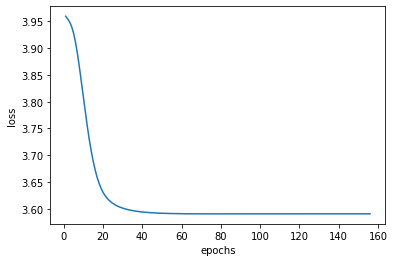

In [14]:
import seaborn as sns

epochs = list(range(1, len(list(history.history['loss']))+1))
loss = history.history['loss']

g = sns.lineplot(epochs, loss, legend= True);
g.set_xlabel('epochs')
g.set_ylabel('loss')

Text(0, 0.5, 'ndcg score')

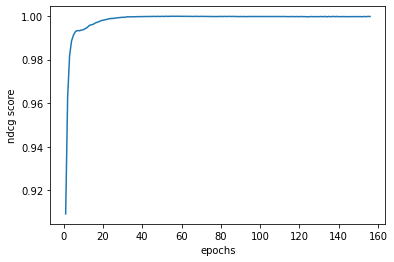

In [15]:
g = sns.lineplot(epochs, history.history['metric/ndcg'], legend= True);
g.set_xlabel('epochs')
g.set_ylabel('ndcg score')

Text(0, 0.5, 'mrr score')

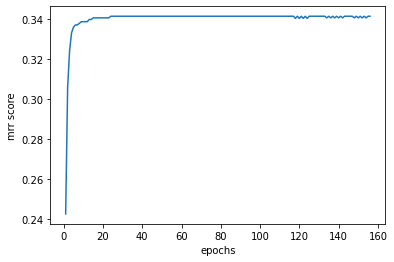

In [16]:
g = sns.lineplot(epochs, history.history['metric/mrr'], legend= True);
g.set_xlabel('epochs')
g.set_ylabel('mrr score')

In [17]:
# Get supplier candidate list.
# for supplier_id in ratings.batch(20):
#   break

# Generate the input for user 42.
inputs = {
    "subject_name":
        tf.expand_dims(tf.repeat('banking_financial', repeats=tf.convert_to_tensor(unique_suppliers).shape[0]), axis=0),
    "supplier_id":
        tf.expand_dims(tf.convert_to_tensor(unique_suppliers), axis=0)
}

# Get movie recommendations for user 42.
scores = model(inputs)
IDS = tfr.utils.sort_by_scores(scores,
                                  [tf.expand_dims(tf.convert_to_tensor(unique_suppliers), axis=0)])[0]

print(f"Top 10 recommendations for subject  'banking_financial': {IDS[0, :10]}")

Top 10 recommendations for subject  'banking_financial': [b'north-america@eng@474' b'north-america@eng@371'
 b'north-america@eng@448' b'europe@eng@359' b'asia@eng@445'
 b'north-america@eng@557' b'europe@fre@591' b'north-america@eng@359'
 b'asia@eng@271' b'europe@eng@593']


## saving weights

In [18]:
# import os

# if not os.path.exists('final_model_weights'):
#     os.makedirs('final_model_weights')
    
# model.save_weights('final_model_weights/')

## Loading Weights

In [19]:
D = RankingModel(suppliers_vocabulary, subjects_vocabulary)

optimizer = optimizers.Adagrad(0.5)

loss = tfr.keras.losses.get(
    loss=tfr.keras.losses.RankingLossKey.SOFTMAX_LOSS, ragged=True)

eval_metrics = [
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=True),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=True)
]

D.compile(optimizer=optimizer, loss=loss, metrics=eval_metrics)

D.load_weights('LTR_Continent_lang_study_subject_final_model_weights/')

In [20]:

# Generate the input for inferance.
inputs = {
    "subject_name":
        tf.expand_dims(tf.repeat('banking_financial', repeats=tf.convert_to_tensor(unique_suppliers).shape[0]), axis=0),
    "supplier_id":
        tf.expand_dims(tf.convert_to_tensor(unique_suppliers), axis=0)
}

# Get movie recommendations.
scores = D(inputs)
IDS = tfr.utils.sort_by_scores(scores,
                                  [tf.expand_dims(tf.convert_to_tensor(unique_suppliers), axis=0)])[0]


print(f"Top 10 recommendations for subject  'banking_financial': {IDS[0, :50]}")

Top 10 recommendations for subject  'banking_financial': [b'north-america@eng@474' b'north-america@eng@371'
 b'north-america@eng@448' b'asia@eng@445' b'north-america@eng@557'
 b'europe@fre@591' b'north-america@eng@558' b'europe@eng@359'
 b'north-america@eng@442' b'north-america@eng@359' b'europe@eng@593'
 b'north-america@eng@600' b'europe@ita@591' b'north-america@eng@572'
 b'asia@eng@271' b'north-america@eng@528' b'europe@ger@537'
 b'oceania@eng@528' b'europe@fre@271' b'oceania@eng@524'
 b'north-america@eng@445' b'north-america@eng@288' b'asia@jpn@588'
 b'north-america@eng@590' b'north-america@eng@404' b'asia@eng@537'
 b'north-america@eng@543' b'north-america@eng@271' b'europe@fre@561'
 b'europe@eng@524' b'north-america@eng@229' b'north-america@eng@520'
 b'asia@eng@113' b'oceania@eng@592' b'asia@may@271' b'oceania@eng@557'
 b'north-america@eng@500' b'north-america@eng@272' b'europe@eng@124'
 b'africa@eng@271' b'north-america@eng@341' b'europe@eng@574'
 b'europe@hun@271' b'north-america